In [1]:
import pandas as pd
import geopandas as gpd
from datetime import date

# Background

This notebook investigates issues relating to the completeness of HMS data. Questions are:
1. How complete are the density readings?
2. How many NA values exist for Start and End?
3. What missing values exist for "Satellite"?
4. What are altitudeMo, tessellate, extrude, visibility?
5. How completely do the datasets cover dates for each year?

This notebook reviews a dataset of HMS smoke data collected from https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Smoke_Polygons/Shapefile/ using code/1_collect_HMS_daily_shapes.py. This dataset underwent the following alterations:
* addition of "year" and "date" columns, with values as strings to enable saving as a shapefile.
* addition of columns for days which previously did not have those columns. That is, where 2005-08-05 previously had no Density column, it now has a Density column with NA values. This is the result of concatenating all daily dataframes.

The original number of rows, column names, and crses for each day's shapefile can be viewed using the metadata csv.

## Load data

In [2]:
# load data
f = "../data/hms_smoke_shapes_2005_2021/hms_smoke_shapes_20050805_20211231.shp"
df = gpd.read_file(f)
df.year = df.year.astype("int32")
df

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
0,0.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-121.32000 50.35000, -121.46800 50.4..."
1,1.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.67300 47.09400, -114.75200 47.0..."
2,2.0,1200,1700,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-114.25200 46.02700, -114.30100 46.1..."
3,3.0,1145,1715,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-78.78100 37.51000, -78.74600 37.500..."
4,4.0,1645,1945,2005-08-05 00:00:00,2005,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-123.90500 42.73000, -123.95400 42.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
439746,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
439747,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
439748,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."
439749,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-102.01601 20.38415, -102.00044 20.4..."


In [3]:
# make df of dates represented in the data
d2005 = (date(2005,12,31)-date(2005,8,4)).days
days = [d2005]
days.extend([365,365,366,365]*4)
dates_df = pd.DataFrame({"year":range(2005,2022), "days": days})
dates_df

,year,days
0,2005,149
1,2006,365
2,2007,365
3,2008,366
4,2009,365
5,2010,365
6,2011,365
7,2012,366
8,2013,365
9,2014,365


In [4]:
def return_size_chart(df, rename="count"):
    return df.reset_index().rename(columns={0:rename})

## Preliminary Stats
How many entries per year?

In [5]:
total_grouped = df.groupby(["year"],dropna=False).size()
total_records = return_size_chart(total_grouped, "total_records")
total_records

,year,total_records
0,2005,6296
1,2006,15453
2,2007,19881
3,2008,23285
4,2009,23517
5,2010,27241
6,2011,33721
7,2012,27972
8,2013,23162
9,2014,18565


Simple chart of number of entries per year:

<AxesSubplot:xlabel='year'>

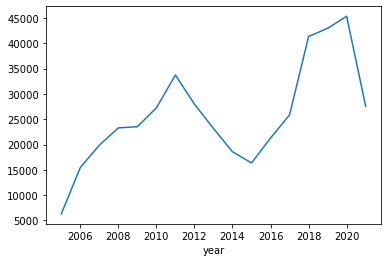

In [6]:
df.groupby(["year"],dropna=False).size().plot()

# Question 1: How complete are the density readings?

This section checks presence of non-null values by year.

**Findings:**
* 2005-2006 have no Density values
* 2007-2010 have thousands of missing Density values
* 2015 has one day with missing density values
* 2018 has one day with missing density values
* The first date for which density is recorded is April 26, 2007

Here's a table of the number of records with missing Density values per year:

In [7]:
na_densities = df.loc[df.Density.isna()].groupby(["year"],dropna=False).size()
total_records.merge(return_size_chart(na_densities, "na_density"), how="left").fillna(0).astype({'na_density': 'int32'})

,year,total_records,na_density
0,2005,6296,6296
1,2006,15453,15453
2,2007,19881,19623
3,2008,23285,5076
4,2009,23517,23369
5,2010,27241,7446
6,2011,33721,0
7,2012,27972,0
8,2013,23162,0
9,2014,18565,0


What's the first available date for which we have data?

In [8]:
df.loc[df.Density.notna()].sort_values("date").head(1)

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
26484,0.0,1245,1615,2007-04-26 00:00:00,2007,5.0,None,None,NaN,NaN,NaN,"POLYGON ((-97.53900 24.31900, -97.04000 24.591..."


The first day we have a Density value recorded is April 26, 2007.

Here is a bar graph comparing total records with records missing densities for each year:

<AxesSubplot:>

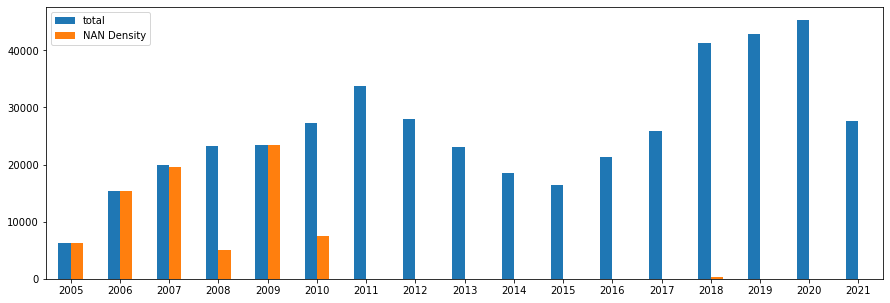

In [9]:
plotter = pd.DataFrame({'total': total_grouped.to_dict(),
                   'NAN Density': na_densities.to_dict()})
ax = plotter.plot.bar(rot=0, figsize=(15,5))

ax

There are 12 entries in 2015 and 306 entries in 2018 with null Density values. What happened there?

In [10]:
df.loc[(df.year =='2015') & df.Density.isna()]

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


In [11]:
df.loc[(df.year =='2018') & df.Density.isna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


3/3/2018 and 1/25/2018 lack Density as well as Start/End values.

How many days per year lack Density values?

In [12]:
nodensity_days = dates_df.merge(df.loc[df.Density.isna()][["year","date"]].groupby(["year"]).nunique().reset_index()).rename(columns={"date":"na_days"})
nodensity_days

,year,days,na_days
0,2005,149,146
1,2006,365,356
2,2007,365,354
3,2008,366,119
4,2009,365,358
5,2010,365,146
6,2015,365,1
7,2018,365,1


Confirm that no dates without Density values also contain entries with Density values:

In [13]:
df1 = df.loc[df.Density.isna()][["year","date"]]
df2 = df.loc[df.Density.notna()][["year","date"]]
df1.merge(df2)

,year,date


# Question 2: How many NA values exist for Start and End?

**Findings:**
* January 25, 2015 and March 3, 2018 are anomalous in their lack of Start and End dates.

In [14]:
# search for NA Start values
na_start = df.loc[(df.Start.isna())].sort_values("date")
na_start

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
219431,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219442,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
219441,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
219439,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
219438,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
288517,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
288516,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
288515,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
288522,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


search for NA end values

In [15]:
na_end = df.loc[(df.End.isna())].sort_values("date")
na_end

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
219431,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,clampToGround,-1.0,1.0,-1.0,"POLYGON ((-80.60100 26.74300, -80.60500 26.764..."
219442,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.66200 30.54600, -86.58700 30.610..."
219441,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-120.60400 38.97900, -120.59000 38.9..."
219439,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-123.84700 43.26200, -123.88300 43.2..."
219438,NaN,None,None,2015-01-25 00:00:00,2015,NaN,None,None,-1.0,1.0,-1.0,"POLYGON ((-86.85700 30.83300, -86.79400 30.939..."
...,...,...,...,...,...,...,...,...,...,...,...,...
288517,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.07062 31.26236, -87.05841 31.184..."
288516,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.31866 30.93765, -86.33575 30.888..."
288515,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-86.47247 30.98892, -86.47247 30.942..."
288522,NaN,None,None,2018-03-03 00:00:00,2018,NaN,None,None,NaN,NaN,NaN,"POLYGON ((-87.54425 31.93375, -87.53692 31.894..."


In [16]:
na_start.equals(na_end)

True

The output of the cell above confirms that the na_start and na_end dataframes contain the same rows.

In [17]:
df.loc[(df.End.isna())].sort_values("date").date.unique()

array(['2015-01-25 00:00:00', '2018-03-03 00:00:00'], dtype=object)

Do either dates have any non-na "Start", "End", or "Density" values?

In [18]:
df.loc[((df.date.str.contains("2015-01-25"))|(df.date.str.contains("2018-03-03"))) & ((df.End.notna())|(df.Start.notna())|(df.Density.notna()))].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry


No.

# Question 3: What missing values exist for "Satellite"? How might present values be used?

**Conclusion:** Before 2017, few "Satellite" values were recorded and data review alone does not clarify how the values present might be effectively used. In and after 2017, tagging is a regular occurrence and could be useful in deciding what data to pick.

How many rows contain satellite values?

In [19]:
df.loc[df.Satellite.notna()].sort_values("date")

,ID,Start,End,date,year,Density,Satellite,altitudeMo,tessellate,extrude,visibility,geometry
85633,NaN,2009271 1330,2009271 1430,2009-09-28 00:00:00,2009,5.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-106.79600 43.59900, -103.95100 42.1..."
85707,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.62200 47.21000, -115.55300 47.4..."
85706,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-120.89700 46.77300, -120.97600 46.6..."
85705,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-113.71100 46.06000, -113.41000 46.4..."
85704,NaN,2009271 2145,2009271 2245,2009-09-28 00:00:00,2009,16.0,NOAA Satellites,None,NaN,NaN,NaN,"POLYGON ((-115.25900 47.16300, -114.92400 47.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...
439745,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-80.86339 26.67656, -80.87560 26.731..."
439746,NaN,2021365 1100,2021365 1600,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-92.22419 19.55040, -92.41493 19.681..."
439747,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-95.21035 16.88020, -95.75144 17.073..."
439748,NaN,2022365 1940,2022365 2330,2021-12-31 00:00:00,2021,5.0,GOES-EAST,None,NaN,NaN,NaN,"POLYGON ((-103.78492 20.64871, -103.67599 20.7..."


What's the occurrence of different Satellite values from 2005-2016?

In [20]:
# count occurrence of density values by year
return_size_chart(df.groupby(["year", "Satellite"],dropna=False).size())

,year,Satellite,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NOAA Satellites,148
5,2009,NaN,23369
6,2010,NOAA Satellites,360
7,2010,NaN,26881
8,2011,NaN,33721
9,2012,NOAA Satellites,71


# Question 4: What are altitudeMo, tessellate, extrude, visibility?

**Conclusion:** Apparent flukes, present only for January 25, 2015.

In [21]:
return_size_chart(df.groupby(["year", "altitudeMo"],dropna=False).size())

,year,altitudeMo,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [22]:
return_size_chart(df.groupby(["year", "tessellate"],dropna=False).size())

,year,tessellate,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [23]:
return_size_chart(df.groupby(["year", "extrude"],dropna=False).size())

,year,extrude,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


In [24]:
return_size_chart(df.groupby(["year", "visibility"],dropna=False).size())

,year,visibility,count
0,2005,NaN,6296
1,2006,NaN,15453
2,2007,NaN,19881
3,2008,NaN,23285
4,2009,NaN,23517
5,2010,NaN,27241
6,2011,NaN,33721
7,2012,NaN,27972
8,2013,NaN,23162
9,2014,NaN,18565


# Question 5: How completely do the datasets cover dates for each year?

**Findings:**
- 54 days had shapefiles with no entries.
- 27 days did not have shapefiles at all.

**Follow-up:**
- Investigate why the shapefiles might be missing - whether the absence is indicative of no smoke plumes across the US for that day or whether it indicates the data is not present.
  - Consider looking at which dates are missing (winter months may indicate no smoke activity)
  - Examine whether the days before and after contained wildfire smoke (this would suggest the data is missing)

In [25]:
# read in metadata file
f = "../data/hms_2005_2021_metadata.csv"
meta_df = pd.read_csv(f)
meta_df

,date,year,columns,entries,crs,missing
0,2005-08-05 00:00:00,2005,"ID, Start, End, geometry, date, year",58.0,epsg:4326,False
1,2005-08-06 00:00:00,2005,"ID, Start, End, geometry, date, year",96.0,epsg:4326,False
2,2005-08-07 00:00:00,2005,"ID, Start, End, geometry, date, year",77.0,epsg:4326,False
3,2005-08-08 00:00:00,2005,"ID, Start, End, geometry, date, year",27.0,epsg:4326,False
4,2005-08-09 00:00:00,2005,NaN,NaN,NaN,True
...,...,...,...,...,...,...
5988,2021-12-27 00:00:00,2021,"Satellite, Start, End, Density, geometry, date...",31.0,epsg:4326,False
5989,2021-12-28 00:00:00,2021,"Satellite, Start, End, Density, geometry, date...",13.0,epsg:4326,False
5990,2021-12-29 00:00:00,2021,"Satellite, Start, End, Density, geometry, date...",12.0,epsg:4326,False
5991,2021-12-30 00:00:00,2021,"Satellite, Start, End, Density, geometry, date...",8.0,epsg:4326,False


In [26]:
# list missing days
missing_df = meta_df.loc[meta_df["missing"] == True]
print(len(missing_df))
missing_df['date']

27


4       2005-08-09 00:00:00
5       2005-08-10 00:00:00
234     2006-03-27 00:00:00
239     2006-04-01 00:00:00
343     2006-07-14 00:00:00
344     2006-07-15 00:00:00
456     2006-11-04 00:00:00
603     2007-03-31 00:00:00
746     2007-08-21 00:00:00
901     2008-01-23 00:00:00
902     2008-01-24 00:00:00
943     2008-03-05 00:00:00
1274    2009-01-30 00:00:00
1342    2009-04-08 00:00:00
2620    2012-10-07 00:00:00
3588    2015-06-02 00:00:00
3667    2015-08-20 00:00:00
3866    2016-03-06 00:00:00
4117    2016-11-12 00:00:00
4283    2017-04-27 00:00:00
4317    2017-05-31 00:00:00
4318    2017-06-01 00:00:00
4339    2017-06-22 00:00:00
4365    2017-07-18 00:00:00
5087    2019-07-10 00:00:00
5118    2019-08-10 00:00:00
5451    2020-07-08 00:00:00
Name: date, dtype: object

In [27]:
# list days that have shapefiles but no entries
no_entries_df = meta_df.loc[meta_df["entries"] == 0]
print(len(no_entries_df))
no_entries_df['date']

54


135     2005-12-18 00:00:00
170     2006-01-22 00:00:00
177     2006-01-29 00:00:00
329     2006-06-30 00:00:00
506     2006-12-24 00:00:00
521     2007-01-08 00:00:00
547     2007-02-03 00:00:00
613     2007-04-10 00:00:00
859     2007-12-12 00:00:00
872     2007-12-25 00:00:00
1035    2008-06-05 00:00:00
1228    2008-12-15 00:00:00
1238    2008-12-25 00:00:00
1239    2008-12-26 00:00:00
1400    2009-06-05 00:00:00
1530    2009-10-13 00:00:00
1593    2009-12-15 00:00:00
1649    2010-02-09 00:00:00
1663    2010-02-23 00:00:00
1969    2010-12-26 00:00:00
2279    2011-11-01 00:00:00
2333    2011-12-25 00:00:00
2454    2012-04-24 00:00:00
2690    2012-12-16 00:00:00
2697    2012-12-23 00:00:00
2709    2013-01-04 00:00:00
2715    2013-01-10 00:00:00
3036    2013-11-27 00:00:00
3037    2013-11-28 00:00:00
3040    2013-12-01 00:00:00
3066    2013-12-27 00:00:00
3076    2014-01-06 00:00:00
3077    2014-01-07 00:00:00
3103    2014-02-02 00:00:00
3425    2014-12-21 00:00:00
3426    2014-12-22 0

In [28]:
# check days present for each year in metadata file
days = return_size_chart(meta_df.groupby(["year"],dropna=False).size())

# get number of missing days for each year
missing = return_size_chart(missing_df.groupby(["year", "missing"],dropna=False).size())

# get number of days that have zero entries in their shapefiles
no_entries = return_size_chart(no_entries_df.groupby(["year", "entries"],dropna=False).size())

# produce a merged table showing the missing and no_entries values for each year
daynums = dates_df\
        .merge(days[['year','count']].rename(columns={"count":"days_present"}), how="left")\
        .merge(no_entries[['year','count']].rename(columns={"count":"no_entries"}), how="left")\
        .merge(missing[['year','count']].rename(columns={"count":"missing"}), how="left")

daynums

,year,days,days_present,no_entries,missing
0,2005,149,149,1.0,2.0
1,2006,365,365,4.0,5.0
2,2007,365,365,5.0,2.0
3,2008,366,366,4.0,3.0
4,2009,365,365,3.0,2.0
5,2010,365,365,3.0,NaN
6,2011,365,365,2.0,NaN
7,2012,366,366,3.0,1.0
8,2013,365,365,6.0,NaN
9,2014,365,365,8.0,NaN


# Additional Reference

Previous studies using HMS smoke data:

## Zhou et al. 2021
* Paper: "[Excess of COVID-19 cases and deaths due to fine particulate matter exposure during the 2020 wildfires in the United States](https://pubmed.ncbi.nlm.nih.gov/34389545/)" 
* Repository: [xiaodan-zhou/covid_wildfire](https://github.com/xiaodan-zhou/covid_wildfire)

HMS datasets in repository are:
* [HMS_county_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_county_2020.csv) 
* [HMS_zipCodes_2020.csv](https://github.com/xiaodan-zhou/covid_wildfire/blob/master/data/HMS_zipCodes_2020.csv).

Both CSVs consist of daily readings where the only value which appears is 5,16, or 27. We can therefore conclude that the value shown is chosen from among plume shapes that intersect with the county, not computed.

In the repo code, only HMS_county_2020.csv is used. The code that produced the CSVs does not appear to be included. Here is where hms_county appears in the repo code:

in Utilities.R:
```R
## merge with hazard data 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("data/HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
hms$GEOID = as.factor(as.character(hms$GEOID))
df = merge(df, hms, by.x=c("date", "FIPS"), by.y=c("date", "GEOID"), all.x=T)
# df = df[df$date <= max(hms$date), ]
rm(hms)
```

in Combine.R:
```R
################################ get hazard data ################################ 
# 0=nosmoke, 5=(0,10)light, 16=(11-20)medium, 27=(21,32)heavy
hms = read.csv("HMS_county_2020.csv")
hms = tidyr::gather(data=hms, key="date", value="hazardmap", -"County", -"GEOID")
hms$date = mdy("01-01-2020") + (as.numeric(substr(hms$date, 2, 5)) - 1)
hms$hazardmap[is.na(hms$hazardmap)] = 0
names(hms)[names(hms) == "GEOID"] = "FIPS"
hms$FIPS = substr(100000 + hms$FIPS, 2, 6)
hms = hms[, c("FIPS", "date", "hazardmap")]
max(hms$date[hms$hazardmap == 27])
...
################################ merge all together ################################ 
...
df = left_join(df, hms, by=c("FIPS", "date"))
df = left_join(df, mobility, by=c("FIPS", "date"))
rm(cases, deaths, pop, pm, climate, hms, mobility)
```

"hazardmap" is the smoke density value. 
```R
################################ wildifre contribution to pm2.5 2020 ################################
### wildfire period scenario one 
df$wildfire = NA
df$wildfire = (df$hazardmap==27)&(!is.na(df$hazardmap))
rows1 = (df$wildfire==T)&(!is.na(df$wildfire))

df$pm_wildfire = 0
df$pm_wildfire[rows1] = pmax(df$pm25[rows1] - df$pm25_history[rows1], 0)
df$pm_ambient = df$pm25 - df$pm_wildfire

# check 
sum(rows1)
rm(rows1)
...
################################ save data ################################ 
write.csv(df, 'moddat_Feb2021.csv', row.names=F)
```